In [1]:
import numpy as np 
import pandas as pd 

import os 
from tqdm import tqdm

import cv2

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
%%time
root = '../input/lgg-mri-segmentation/kaggle_3m'

def get_images_path():
    images = []
    labels = []
    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters): 
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels

def read_images(paths, tipefile):
    images = []
    
    if tipefile == 'images':
        for f in tqdm(paths):
            img = read_image(f)
            images.append(img)    
    else:
        
        for f in tqdm(paths):
            img = read_mask(f)

            images.append(img)
    
    imgs1 = np.array(images)
    
    return imgs1
    
#  
def read_image(path):
    
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [3]:
imgs, labels = get_images_path()
images = read_images(imgs, 'images')
masks = read_images(labels, 'masks')

100%|██████████| 3929/3929 [00:26<00:00, 148.71it/s]


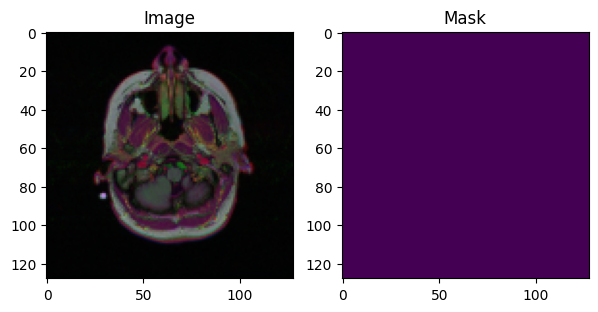

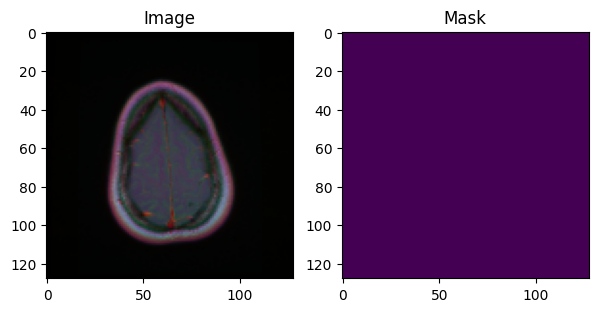

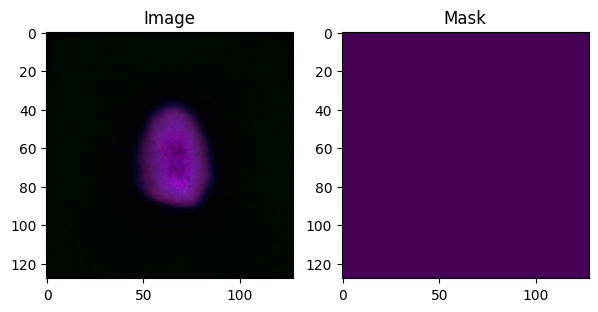

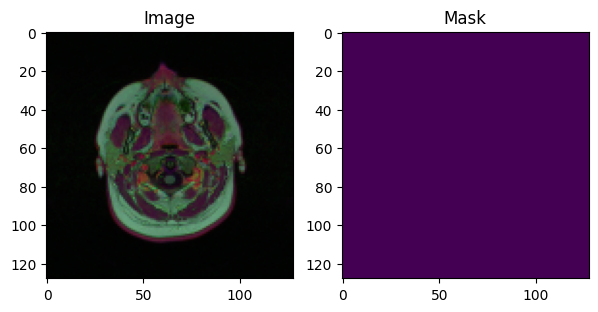

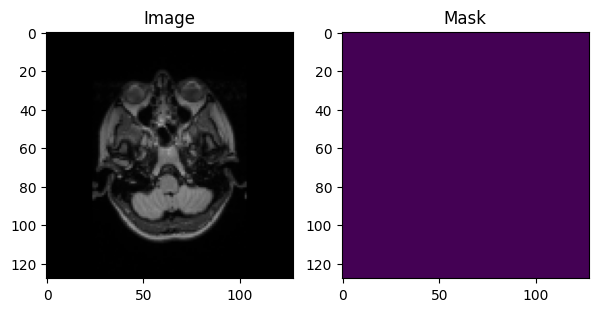

In [4]:
def plot_image(image, mask):
    plt.figure(figsize=(7, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')
    
    
n = 5
l = [random.randint(0,1000) for _ in range(n)]

for i in l:
    plot_image(images[i], masks[i])

In [5]:
instance = []
for i in range(masks.shape[0]):
    
    if sum(sum(masks[i])) == 0:
        instance.append('neg')
    else:
        instance.append('pos')

count = 0
for i in range(len(instance)):
    if instance[i] == 'pos':
        count += 1
print('Número de casos con anomalía cerebral: ', count)

count = 0
for i in range(len(instance)):
    if instance[i] == 'neg':
        count += 1
print('Número de casos sin anomalía cerebral: ', count)

Número de casos con anomalía cerebral:  1373
Número de casos sin anomalía cerebral:  2556


In [6]:
n = images.shape[0]

img = []
msk = []

for i in range(n):
    if instance[i] == 'pos':
        img.append(images[i])
        msk.append(masks[i])
        
img = np.array(img)
msk = np.array(msk)

print('Set de imágenes ',img.shape)
print('Set de mascaras ',msk.shape)

Set de imágenes  (1373, 128, 128, 3)
Set de mascaras  (1373, 128, 128, 1)


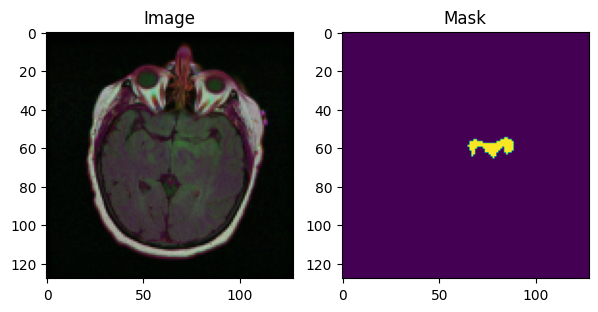

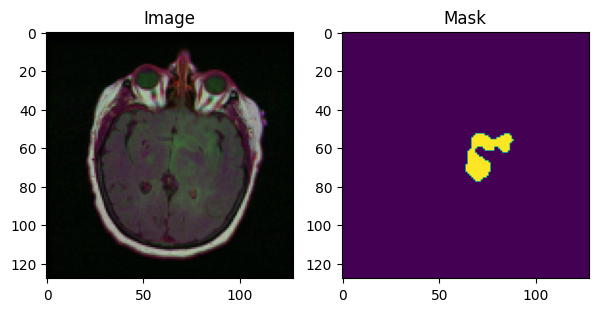

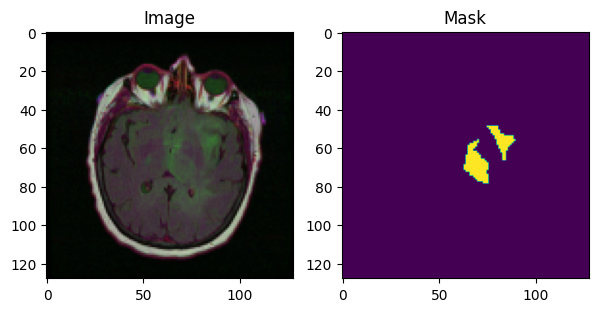

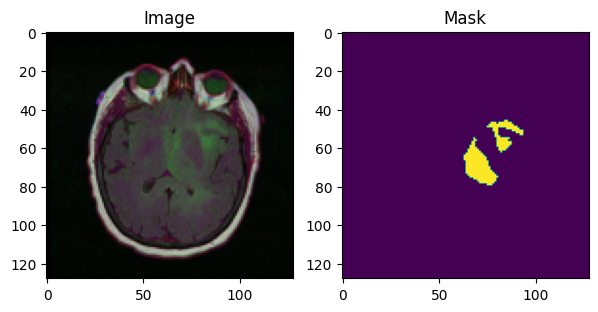

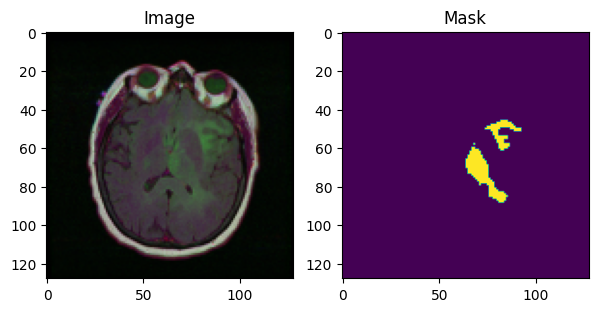

In [7]:
n = 5
for i in range(5):
    plot_image(img[i],msk[i])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(img, msk, test_size = .25, random_state = 288)

In [9]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .50, random_state = 288)

In [10]:
print('#'*10 + ' Images ' + '#'*10)
print('X_train shape: ',  X_train.shape)
print('X_val shape:   ',  X_val.shape)
print('X_test shape:  ',  X_test.shape)
print('\n')
print('#'*10 + ' Masks ' + '#'*10)
print('y_train shape: ',  y_train.shape)
print('y_val shape:   ',  y_val.shape)
print('y_test shape:  ',  y_test.shape)

########## Images ##########
X_train shape:  (1029, 128, 128, 3)
X_val shape:    (172, 128, 128, 3)
X_test shape:   (172, 128, 128, 3)


########## Masks ##########
y_train shape:  (1029, 128, 128, 1)
y_val shape:    (172, 128, 128, 1)
y_test shape:   (172, 128, 128, 1)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np

# Asegurarnos de que se está utilizando un dispositivo con CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
class DeepLabV3(nn.Module):
    def __init__(self, num_classes=1):
        super(DeepLabV3, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)['out']


In [13]:
class CustomDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Transforms
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.ToTensor()
])

# Datos (X_train, X_val, X_test, y_train, y_val, y_test deben estar previamente cargados como arrays de NumPy)
train_dataset = CustomDataset(X_train, y_train, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = CustomDataset(X_val, y_val, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = CustomDataset(X_test, y_test, image_transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [14]:
# Modelo
model = DeepLabV3(num_classes=1).to(device)

# Función de pérdida y optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Función de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            # Adelante
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Atrás
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.float32)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    return model

# Entrenar el modelo
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 161MB/s]


Epoch 0/24, Train Loss: 0.4491, Val Loss: 0.2718
Epoch 1/24, Train Loss: 0.2143, Val Loss: 0.1654
Epoch 2/24, Train Loss: 0.1373, Val Loss: 0.1109
Epoch 3/24, Train Loss: 0.0976, Val Loss: 0.0813
Epoch 4/24, Train Loss: 0.0738, Val Loss: 0.0637
Epoch 5/24, Train Loss: 0.0603, Val Loss: 0.0560
Epoch 6/24, Train Loss: 0.0502, Val Loss: 0.0470
Epoch 7/24, Train Loss: 0.0434, Val Loss: 0.0415
Epoch 8/24, Train Loss: 0.0381, Val Loss: 0.0369
Epoch 9/24, Train Loss: 0.0344, Val Loss: 0.0333
Epoch 10/24, Train Loss: 0.0314, Val Loss: 0.0320
Epoch 11/24, Train Loss: 0.0277, Val Loss: 0.0291
Epoch 12/24, Train Loss: 0.0259, Val Loss: 0.0282
Epoch 13/24, Train Loss: 0.0237, Val Loss: 0.0265
Epoch 14/24, Train Loss: 0.0224, Val Loss: 0.0256
Epoch 15/24, Train Loss: 0.0211, Val Loss: 0.0248
Epoch 16/24, Train Loss: 0.0198, Val Loss: 0.0242
Epoch 17/24, Train Loss: 0.0189, Val Loss: 0.0238
Epoch 18/24, Train Loss: 0.0181, Val Loss: 0.0223
Epoch 19/24, Train Loss: 0.0171, Val Loss: 0.0224
Epoch 20/2

In [15]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item() * images.size(0)

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

# Evaluar el modelo
evaluate_model(model, test_loader, criterion)


Test Loss: 0.0197


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

def evaluate_model_with_metrics(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_masks = []
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > 0.5).astype(np.uint8)
            masks = masks.cpu().numpy().astype(np.uint8)

            all_preds.extend(preds)
            all_masks.extend(masks)

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
    # Flatten the arrays for metric calculation
    all_preds = np.concatenate([p.flatten() for p in all_preds])
    all_masks = np.concatenate([m.flatten() for m in all_masks])
    
    precision = precision_score(all_masks, all_preds)
    recall = recall_score(all_masks, all_preds)
    f1 = f1_score(all_masks, all_preds)
    iou = jaccard_score(all_masks, all_preds)
    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'IoU: {iou:.4f}')

# Evaluar el modelo con métricas adicionales
evaluate_model_with_metrics(model, test_loader, criterion)


Test Loss: 0.0197
Precision: 0.8795
Recall: 0.8719
F1 Score: 0.8757
IoU: 0.7788


In [17]:
import matplotlib.pyplot as plt

def visualize_predictions(images, masks, preds, num_images=5):
    plt.figure(figsize=(15, num_images * 5))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        mask = masks[i].cpu().numpy().squeeze()
        pred = preds[i].cpu().numpy().squeeze()

        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(pred, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Test Loss: 0.0011
Precision: 0.7995
Recall: 0.8899
F1 Score: 0.8423
IoU: 0.7276


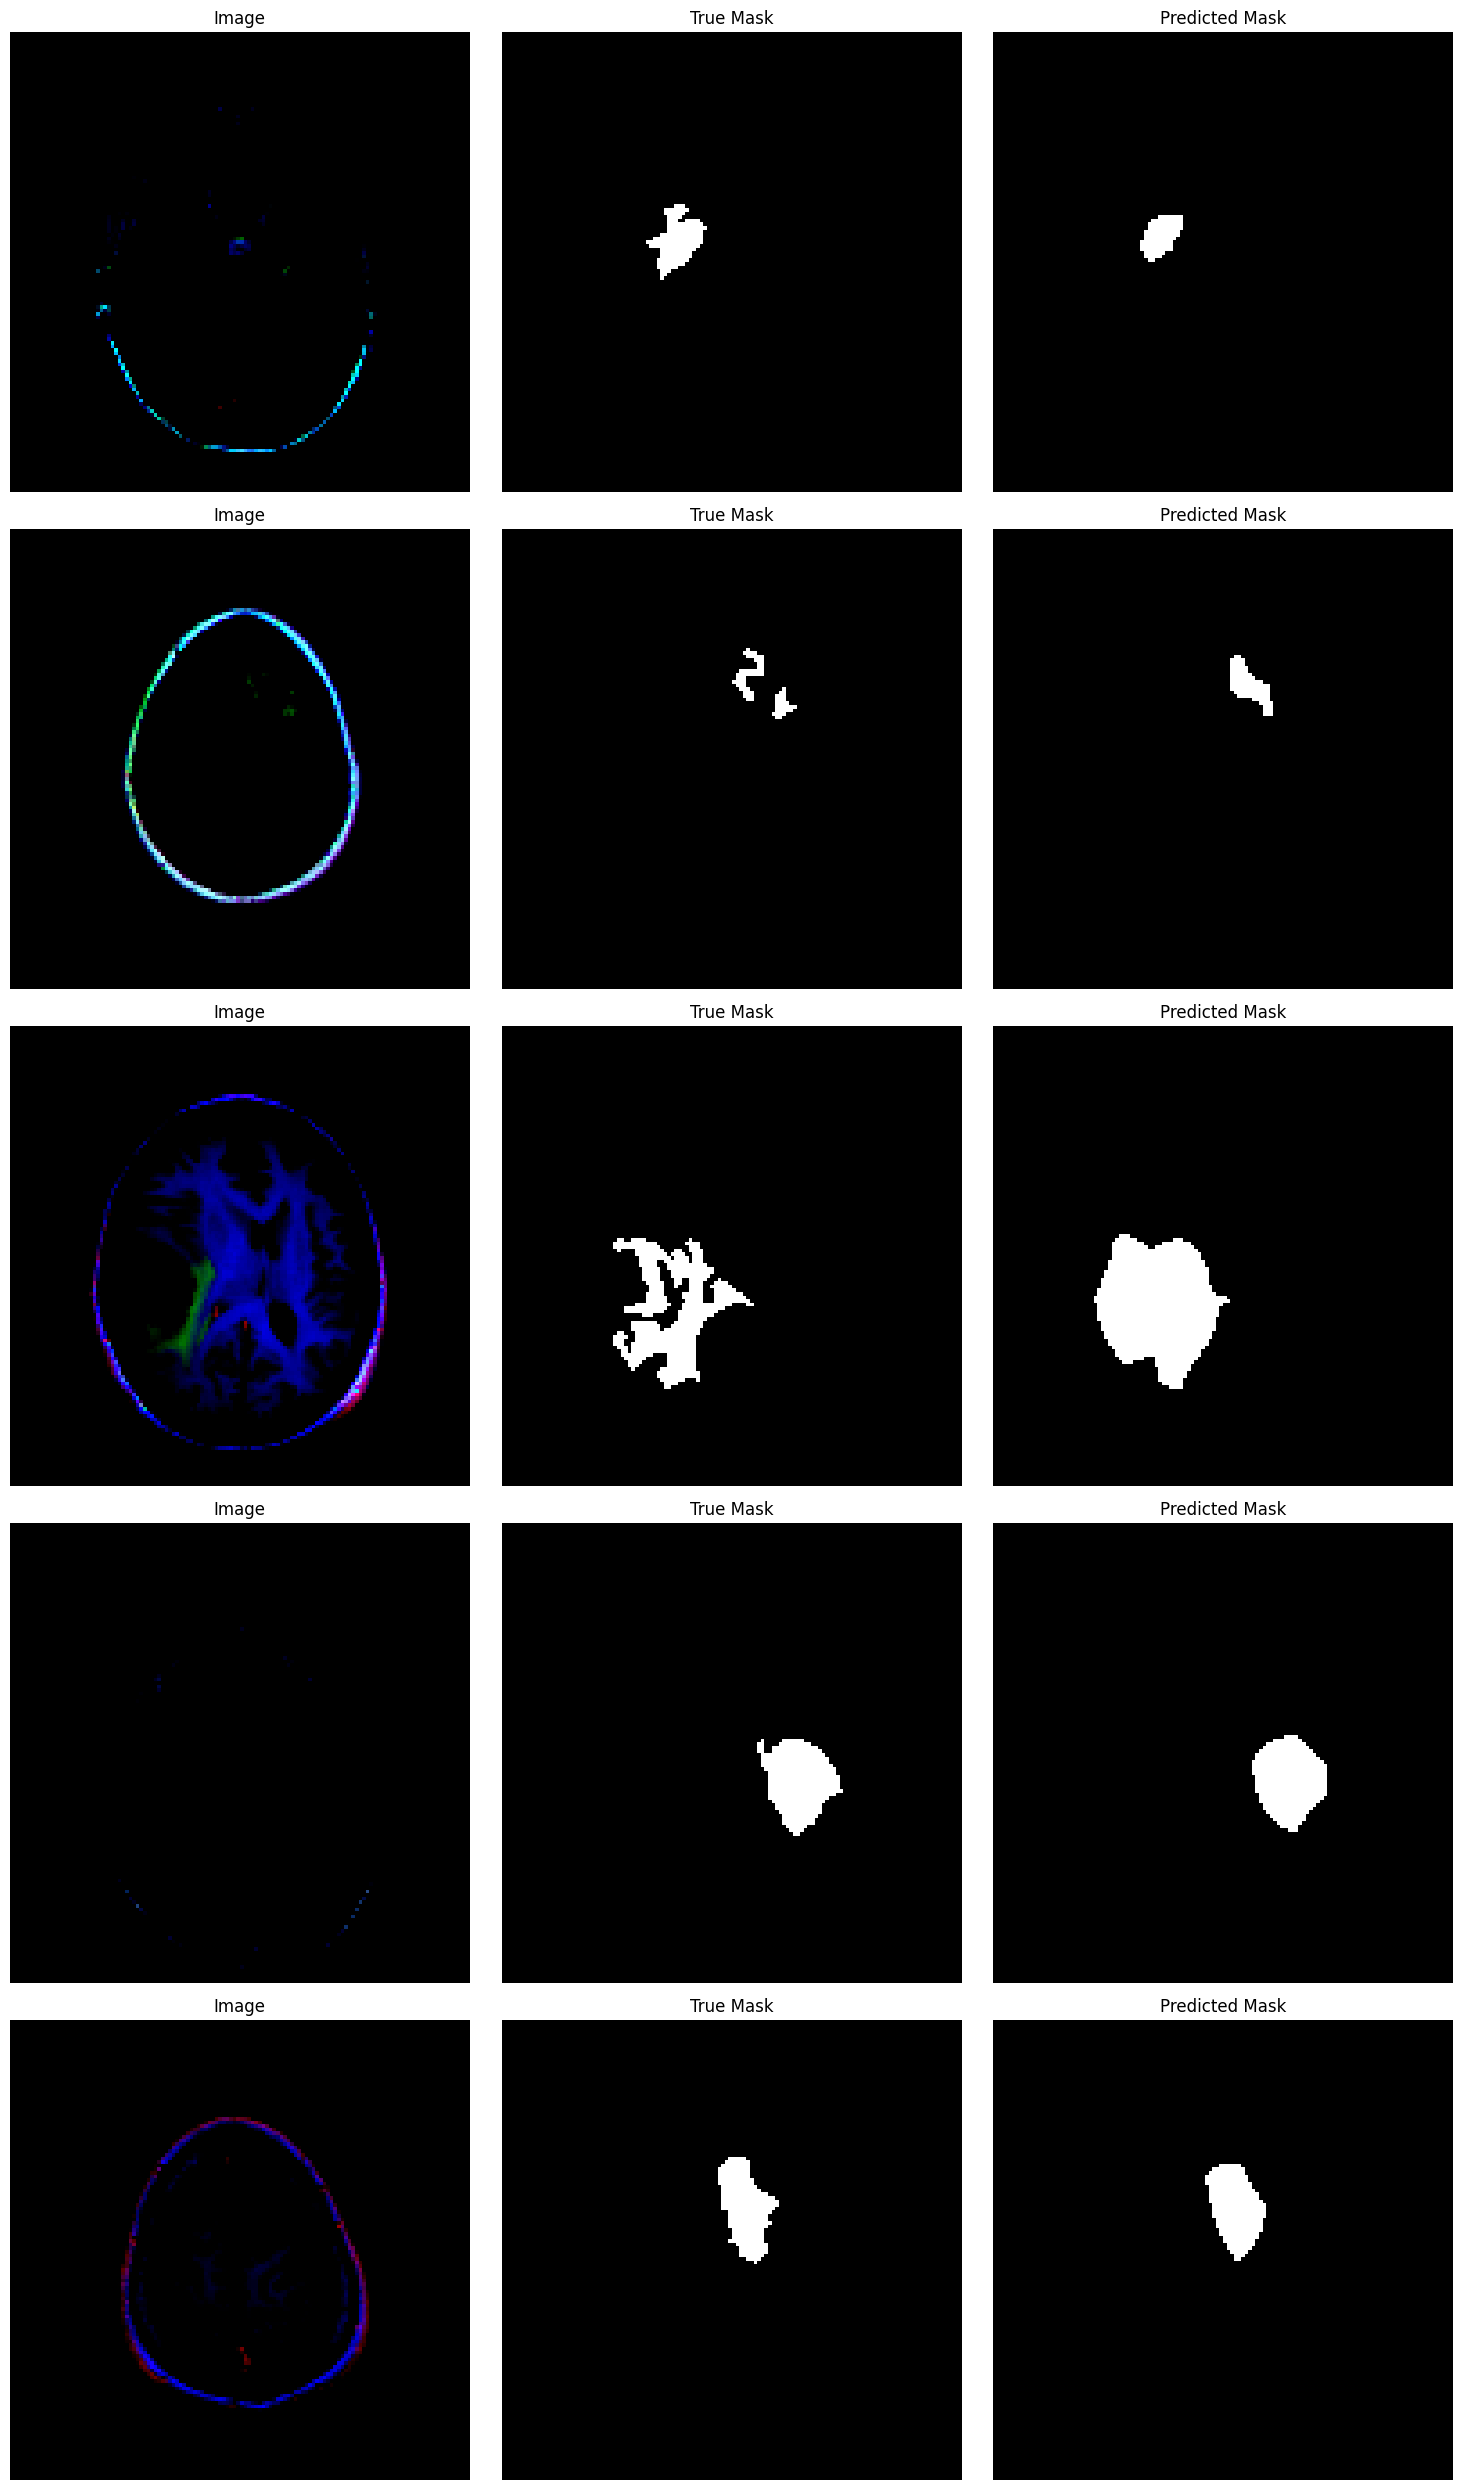

In [18]:
def evaluate_and_visualize(model, test_loader, criterion, num_images=5):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_masks = []
    sample_images = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs).cpu()
            preds = (preds > 0.5).type(torch.uint8)
            masks = masks.cpu().type(torch.uint8)

            all_preds.extend(preds)
            all_masks.extend(masks)
            sample_images.extend(images.cpu())

            if len(sample_images) >= num_images:
                break

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
    # Flatten the arrays for metric calculation
    all_preds_flat = np.concatenate([p.numpy().flatten() for p in all_preds])
    all_masks_flat = np.concatenate([m.numpy().flatten() for m in all_masks])
    
    precision = precision_score(all_masks_flat, all_preds_flat)
    recall = recall_score(all_masks_flat, all_preds_flat)
    f1 = f1_score(all_masks_flat, all_preds_flat)
    iou = jaccard_score(all_masks_flat, all_preds_flat)
    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'IoU: {iou:.4f}')

    # Visualización
    visualize_predictions(sample_images, all_masks, all_preds, num_images=num_images)

# Evaluar y visualizar
evaluate_and_visualize(model, test_loader, criterion, num_images=5)


In [19]:
def denormalize(image, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image


In [20]:
def visualize_predictions(images, masks, preds, num_images=5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    plt.figure(figsize=(15, num_images * 5))
    for i in range(num_images):
        image = denormalize(images[i].cpu(), mean, std)
        mask = masks[i].cpu().numpy().squeeze()
        pred = preds[i].cpu().numpy().squeeze()

        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(pred, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Test Loss: 0.0011
Precision: 0.7995
Recall: 0.8899
F1 Score: 0.8423
IoU: 0.7276


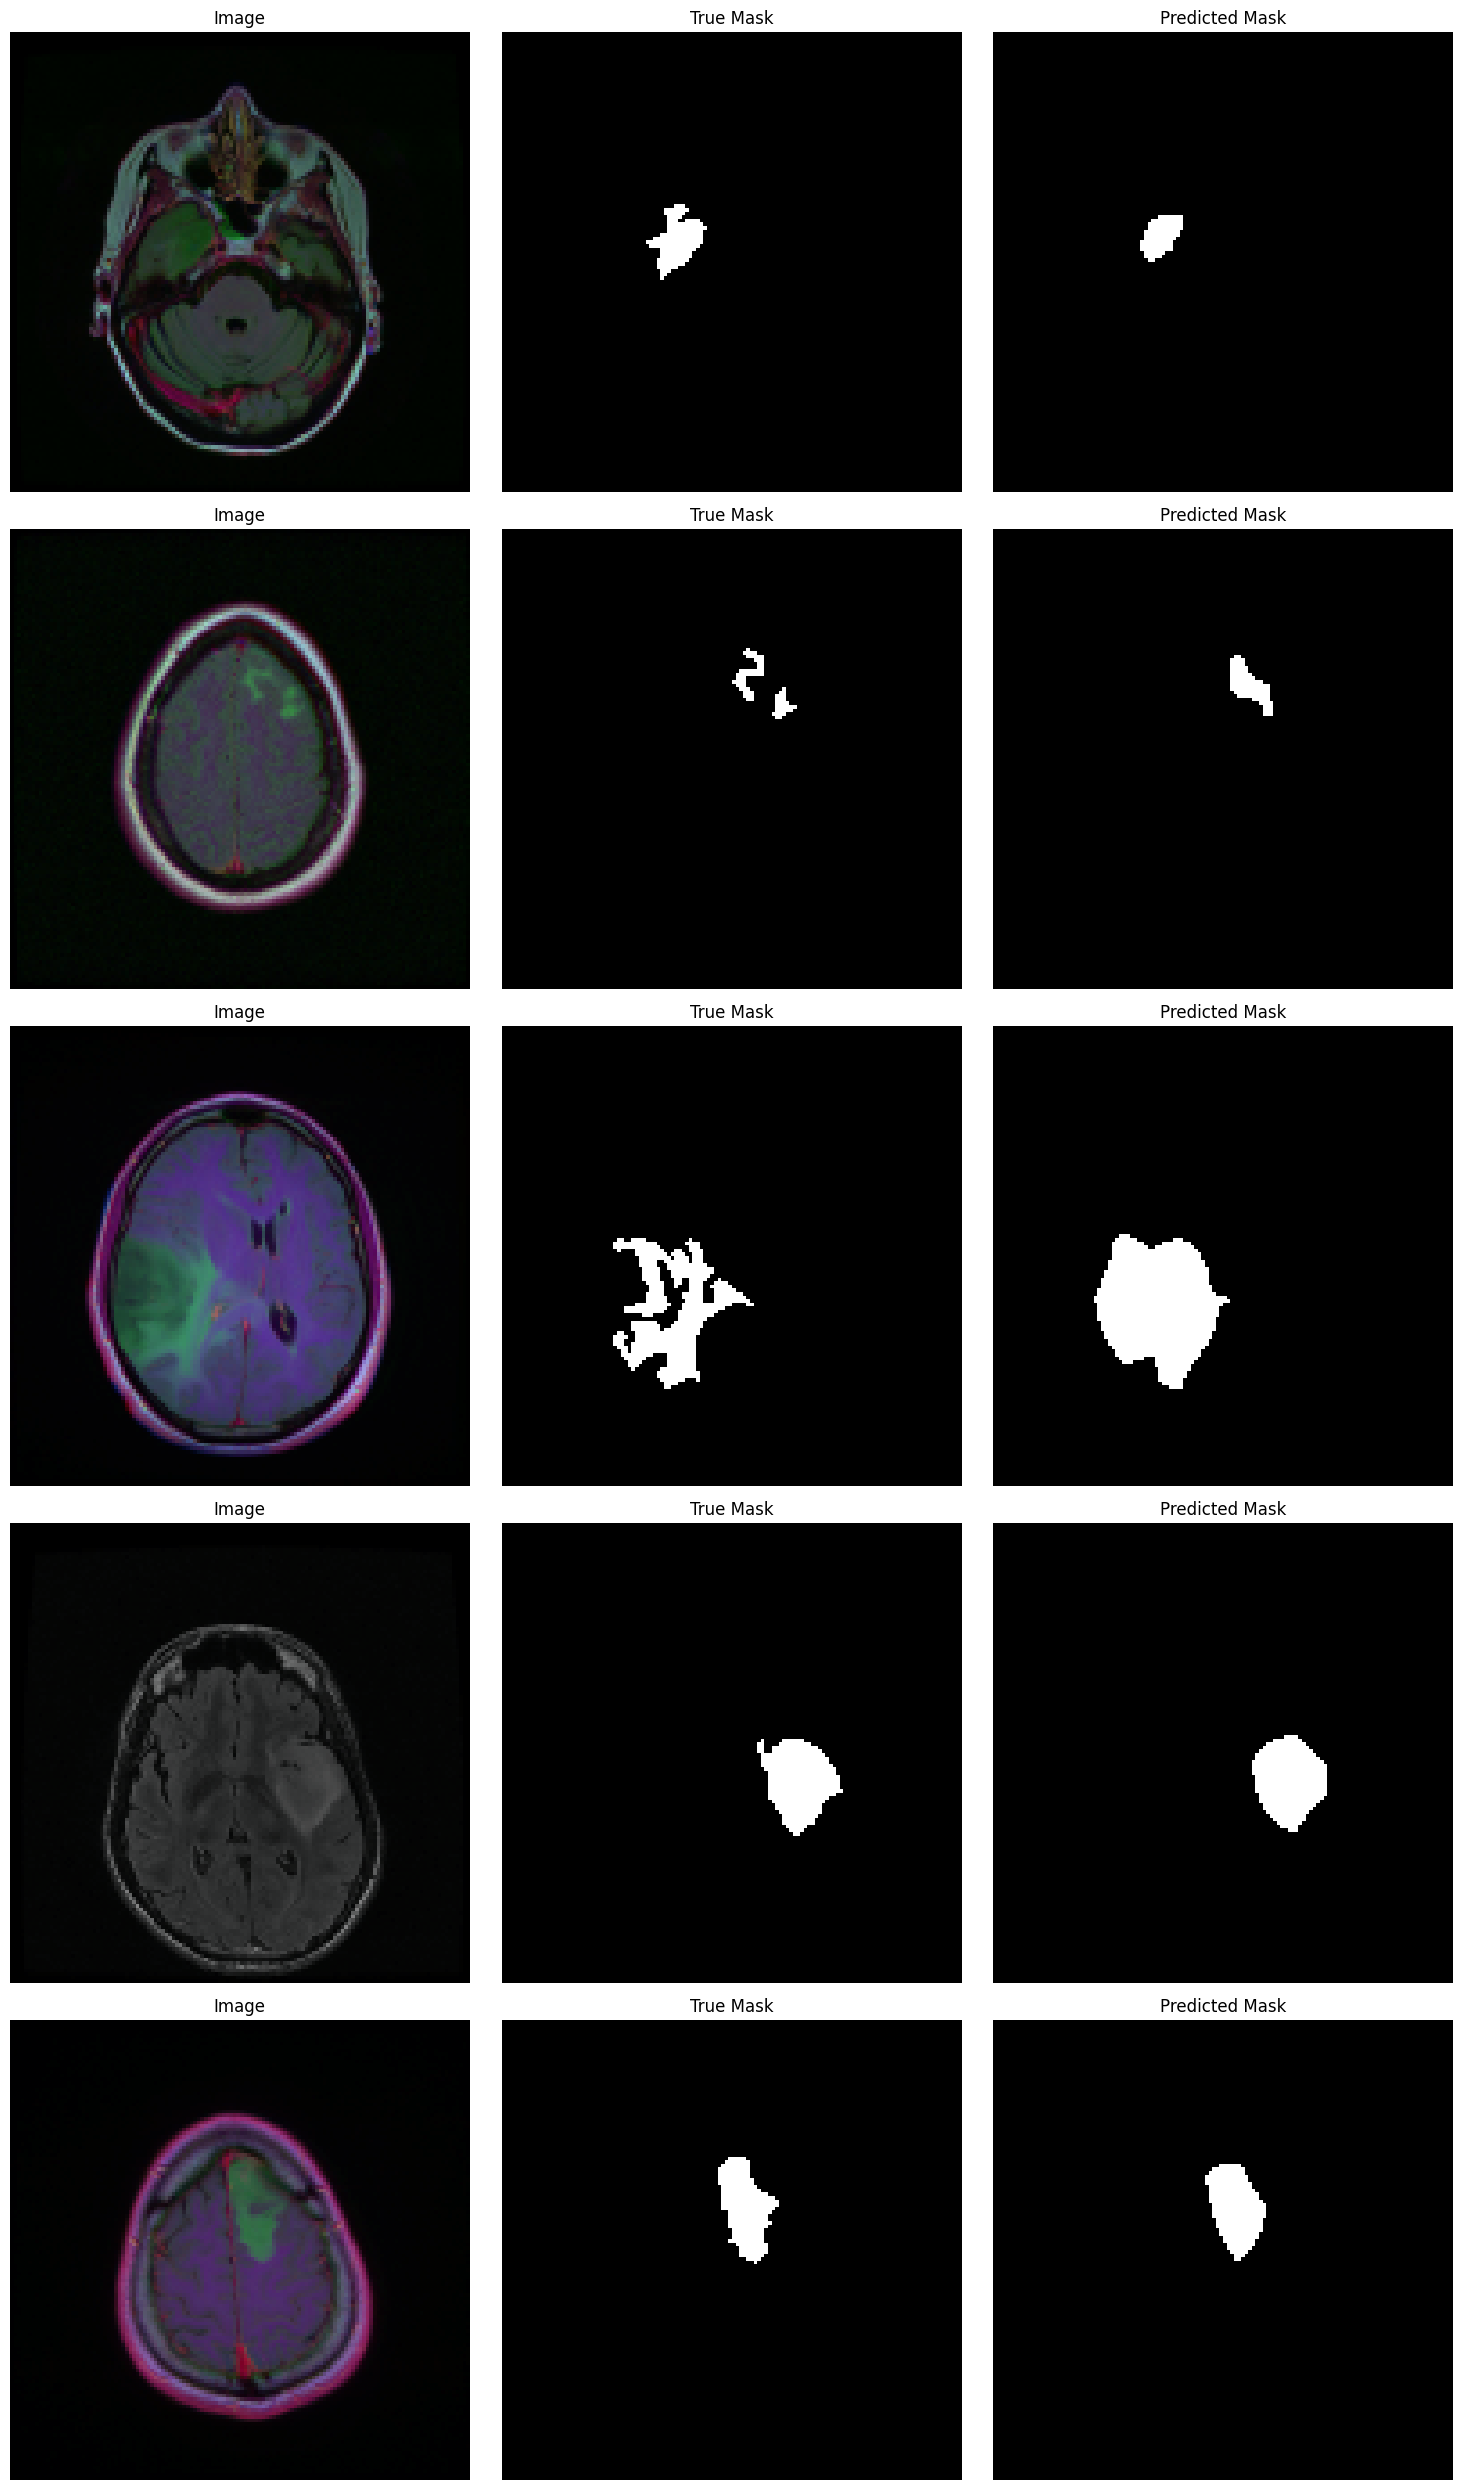

In [21]:
def evaluate_and_visualize(model, test_loader, criterion, num_images=5):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_masks = []
    sample_images = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs).cpu()
            preds = (preds > 0.5).type(torch.uint8)
            masks = masks.cpu().type(torch.uint8)

            all_preds.extend(preds)
            all_masks.extend(masks)
            sample_images.extend(images.cpu())

            if len(sample_images) >= num_images:
                break

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
    # Flatten the arrays for metric calculation
    all_preds_flat = np.concatenate([p.numpy().flatten() for p in all_preds])
    all_masks_flat = np.concatenate([m.numpy().flatten() for m in all_masks])
    
    precision = precision_score(all_masks_flat, all_preds_flat)
    recall = recall_score(all_masks_flat, all_preds_flat)
    f1 = f1_score(all_masks_flat, all_preds_flat)
    iou = jaccard_score(all_masks_flat, all_preds_flat)
    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'IoU: {iou:.4f}')

    # Visualización
    visualize_predictions(sample_images, all_masks, all_preds, num_images=num_images)

# Evaluar y visualizar
evaluate_and_visualize(model, test_loader, criterion, num_images=5)
